In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

# Laad gecategoriseerde data
df = pd.read_csv('../data/processed/transactions_categorized.csv')
df['Date'] = pd.to_datetime(df['Date'])

print("="*60)
print("DATA LOADED FOR SPENDING PREDICTIONS")
print("="*60)
print(f"Total transactions: {len(df)}")
print(f"Date range: {df['Date'].min().date()} to {df['Date'].max().date()}")
print(f"Total days: {(df['Date'].max() - df['Date'].min()).days}")
print(f"\nCategories: {df['Final_Category'].nunique()}")

DATA LOADED FOR SPENDING PREDICTIONS
Total transactions: 1631
Date range: 2024-12-08 to 2025-12-08
Total days: 365

Categories: 24


In [2]:
print("="*60)
print("AGGREGATING MONTHLY SPENDING PER CATEGORY")
print("="*60)

# Exclude savings, transfers, en ATM withdrawals (zijn geen echte uitgaven)
# Alleen expenses (negatieve bedragen)
df_expenses = df[
    (df['Amount'] < 0) & 
    (~df['Final_Category'].isin(['saving', 'transfer', 'atm']))
].copy()

df_expenses['Amount_Abs'] = df_expenses['Amount'].abs()

print(f"✅ Filtered expenses (excluded: savings, transfer, atm)")
print(f"Total expense transactions: {len(df_expenses)}")
print(f"Excluded transactions: {len(df[df['Amount'] < 0]) - len(df_expenses)}")

# Maak jaar-maand kolom
df_expenses['Year_Month'] = df_expenses['Date'].dt.to_period('M')

# Aggregeer per maand per categorie
monthly_spending = df_expenses.groupby(['Year_Month', 'Final_Category']).agg({
    'Amount_Abs': 'sum',
    'Date': 'count'
}).reset_index()

monthly_spending.columns = ['Year_Month', 'Category', 'Total_Spent', 'Transaction_Count']

print(f"\n✅ Monthly aggregation complete!")
print(f"\nMonths covered: {monthly_spending['Year_Month'].nunique()}")
print(f"Categories: {monthly_spending['Category'].nunique()}")
print(f"Total month-category combinations: {len(monthly_spending)}")

print("\nSample of monthly spending:")
print(monthly_spending.head(10))

# Toon spending per maand (totaal)
print("\n" + "="*60)
print("TOTAL SPENDING PER MONTH (excluding savings/transfers)")
print("="*60)
monthly_total = df_expenses.groupby('Year_Month')['Amount_Abs'].sum().reset_index()
monthly_total.columns = ['Month', 'Total_Spent']
print(monthly_total)

AGGREGATING MONTHLY SPENDING PER CATEGORY
✅ Filtered expenses (excluded: savings, transfer, atm)
Total expense transactions: 1173
Excluded transactions: 120

✅ Monthly aggregation complete!

Months covered: 13
Categories: 19
Total month-category combinations: 173

Sample of monthly spending:
  Year_Month      Category  Total_Spent  Transaction_Count
0    2024-12      Gambling        45.00                  5
1    2024-12      bar_cafe        35.05                  2
2    2024-12       fitness        29.99                  1
3    2024-12        online       149.54                  8
4    2024-12   other_shops        25.00                  1
5    2024-12          rent       400.00                  1
6    2024-12    restaurant        45.10                  4
7    2024-12  subscription        42.53                  2
8    2024-12   supermarket       215.30                 14
9    2024-12         taxes        48.00                  1

TOTAL SPENDING PER MONTH (excluding savings/transfers)
  

VISUALIZING HISTORICAL SPENDING TRENDS

✅ Visualization saved: visualizations/06_spending_trends.png


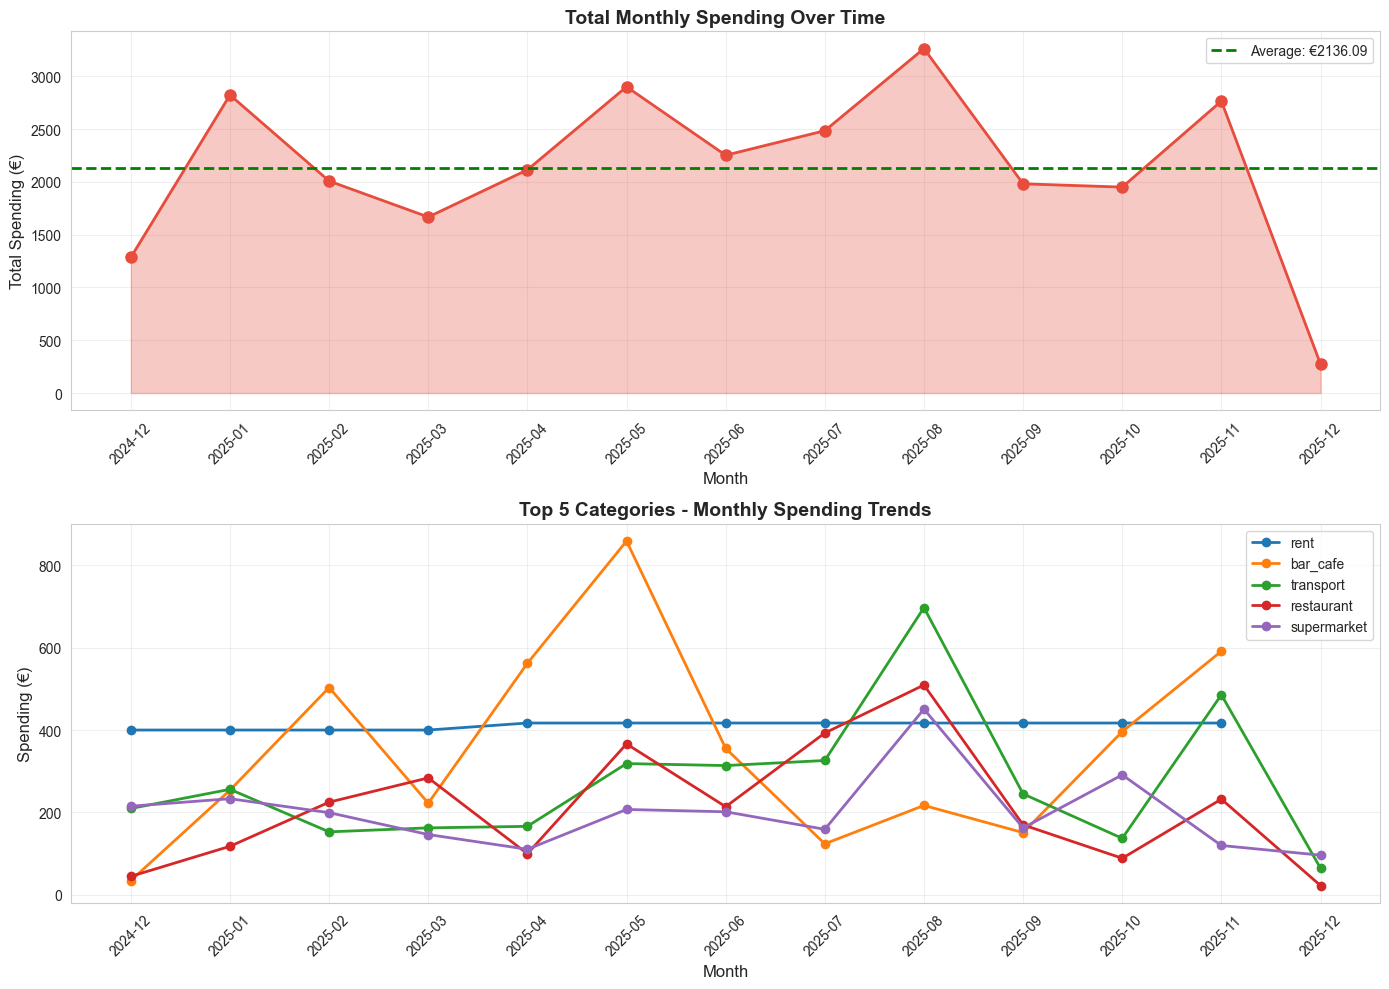

In [3]:
print("="*60)
print("VISUALIZING HISTORICAL SPENDING TRENDS")
print("="*60)

# Top 5 spending categories
top_categories = df_expenses.groupby('Final_Category')['Amount_Abs'].sum().nlargest(5).index

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Total monthly spending
monthly_total['Month_Str'] = monthly_total['Month'].astype(str)
axes[0].plot(monthly_total['Month_Str'], monthly_total['Total_Spent'], 
             marker='o', linewidth=2, markersize=8, color='#e74c3c')
axes[0].fill_between(range(len(monthly_total)), monthly_total['Total_Spent'], 
                      alpha=0.3, color='#e74c3c')
axes[0].set_xlabel('Month', fontsize=12)
axes[0].set_ylabel('Total Spending (€)', fontsize=12)
axes[0].set_title('Total Monthly Spending Over Time', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Add average line
avg_spending = monthly_total['Total_Spent'].mean()
axes[0].axhline(y=avg_spending, color='green', linestyle='--', linewidth=2, 
                label=f'Average: €{avg_spending:.2f}')
axes[0].legend()

# Plot 2: Top 5 categories over time
for category in top_categories:
    cat_data = monthly_spending[monthly_spending['Category'] == category].copy()
    cat_data['Month_Str'] = cat_data['Year_Month'].astype(str)
    axes[1].plot(cat_data['Month_Str'], cat_data['Total_Spent'], 
                 marker='o', linewidth=2, label=category)

axes[1].set_xlabel('Month', fontsize=12)
axes[1].set_ylabel('Spending (€)', fontsize=12)
axes[1].set_title('Top 5 Categories - Monthly Spending Trends', fontsize=14, fontweight='bold')
axes[1].legend(loc='best')
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('../visualizations/06_spending_trends.png', dpi=300, bbox_inches='tight')
print("\n✅ Visualization saved: visualizations/06_spending_trends.png")
plt.show()

In [4]:
print("="*60)
print("TRAINING PREDICTION MODELS")
print("="*60)

# Selecteer top 10 categories om te voorspellen
top_10_categories = df_expenses.groupby('Final_Category')['Amount_Abs'].sum().nlargest(10).index

predictions = {}

for category in top_10_categories:
    print(f"\nTraining model for: {category}")
    
    # Filter data voor deze categorie
    cat_data = monthly_spending[monthly_spending['Category'] == category].copy()
    
    # Check if we have enough data
    if len(cat_data) < 3:
        print(f"  ⚠️ Not enough data (only {len(cat_data)} months)")
        continue
    
    # Sort by month
    cat_data = cat_data.sort_values('Year_Month').reset_index(drop=True)
    
    # Create features (month number)
    cat_data['Month_Number'] = range(len(cat_data))
    
    # Features en target
    X = cat_data[['Month_Number']].values
    y = cat_data['Total_Spent'].values
    
    # Train simple linear regression
    model = LinearRegression()
    model.fit(X, y)
    
    # Predict next month
    next_month_num = len(cat_data)
    next_month_pred = model.predict([[next_month_num]])[0]
    
    # Calculate model performance on historical data
    y_pred_hist = model.predict(X)
    mae = mean_absolute_error(y, y_pred_hist)
    
    predictions[category] = {
        'prediction': next_month_pred,
        'avg_spending': cat_data['Total_Spent'].mean(),
        'recent_spending': cat_data['Total_Spent'].iloc[-1] if len(cat_data) > 0 else 0,
        'mae': mae,
        'months_data': len(cat_data)
    }
    
    print(f"  ✅ Average: €{predictions[category]['avg_spending']:.2f}")
    print(f"  ✅ Last month: €{predictions[category]['recent_spending']:.2f}")
    print(f"  📈 Predicted next month: €{next_month_pred:.2f}")
    print(f"  📊 Model MAE: €{mae:.2f}")

print("\n" + "="*60)
print("ALL PREDICTIONS COMPLETE")
print("="*60)

TRAINING PREDICTION MODELS

Training model for: rent
  ✅ Average: €411.33
  ✅ Last month: €417.00
  📈 Predicted next month: €423.70
  📊 Model MAE: €3.93

Training model for: bar_cafe
  ✅ Average: €355.86
  ✅ Last month: €591.09
  📈 Predicted next month: €426.04
  📊 Model MAE: €181.83

Training model for: transport
  ✅ Average: €272.03
  ✅ Last month: €64.88
  📈 Predicted next month: €330.87
  📊 Model MAE: €115.11

Training model for: restaurant
  ✅ Average: €212.98
  ✅ Last month: €22.85
  📈 Predicted next month: €228.25
  📊 Model MAE: €112.75

Training model for: supermarket
  ✅ Average: €199.62
  ✅ Last month: €96.50
  📈 Predicted next month: €190.65
  📊 Model MAE: €60.68

Training model for: health
  ✅ Average: €207.10
  ✅ Last month: €2.49
  📈 Predicted next month: €-33.39
  📊 Model MAE: €129.90

Training model for: online
  ✅ Average: €158.53
  ✅ Last month: €15.25
  📈 Predicted next month: €143.22
  📊 Model MAE: €82.25

Training model for: Gambling
  ✅ Average: €103.42
  ✅ Last m

VISUALIZING PREDICTIONS

✅ Visualization saved: visualizations/07_spending_predictions.png


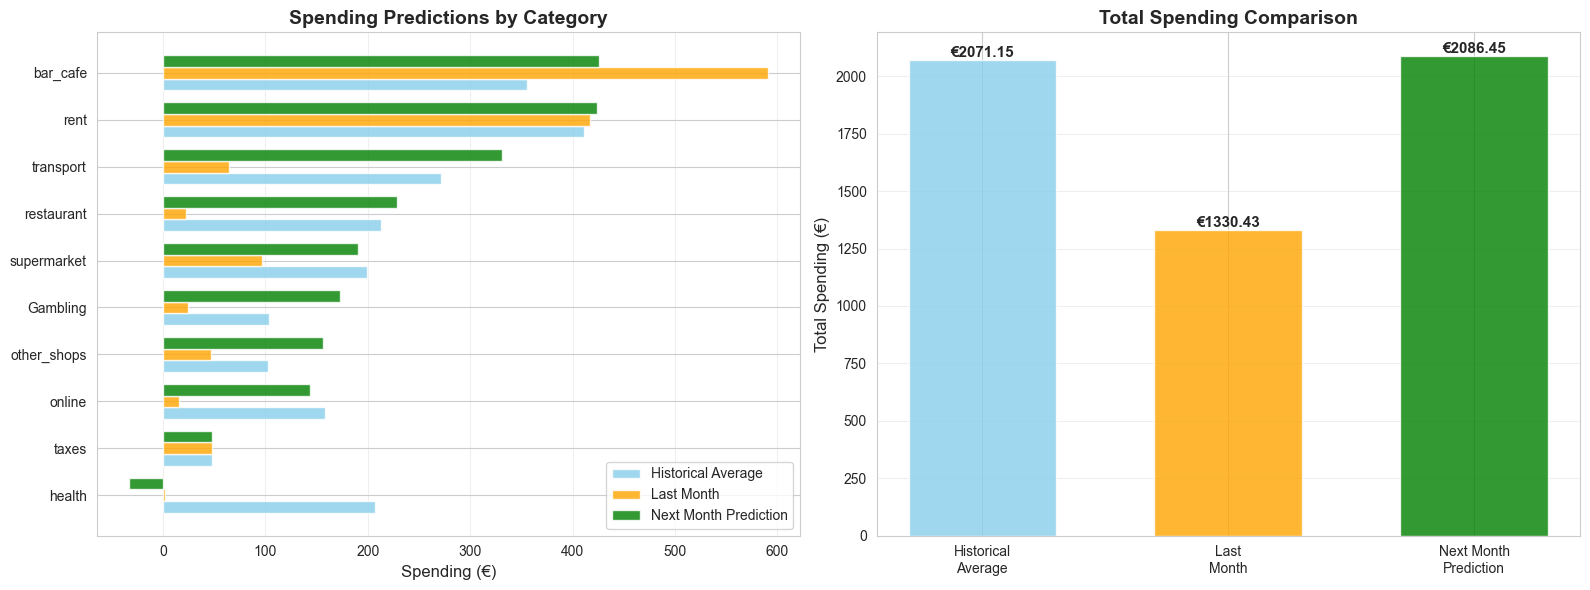


PREDICTION SUMMARY
Total predicted spending next month: €2086.45
Historical average: €2071.15
Last month actual: €1330.43

Difference from average: €+15.30 (+0.7%)


In [5]:
print("="*60)
print("VISUALIZING PREDICTIONS")
print("="*60)

# Create predictions dataframe
pred_df = pd.DataFrame([
    {
        'Category': cat,
        'Predicted': data['prediction'],
        'Average': data['avg_spending'],
        'Last_Month': data['recent_spending']
    }
    for cat, data in predictions.items()
])

# Sort by prediction
pred_df = pred_df.sort_values('Predicted', ascending=True)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Predicted vs Average vs Last Month
x = range(len(pred_df))
width = 0.25

axes[0].barh([i - width for i in x], pred_df['Average'], width, 
             label='Historical Average', color='skyblue', alpha=0.8)
axes[0].barh(x, pred_df['Last_Month'], width, 
             label='Last Month', color='orange', alpha=0.8)
axes[0].barh([i + width for i in x], pred_df['Predicted'], width, 
             label='Next Month Prediction', color='green', alpha=0.8)

axes[0].set_yticks(x)
axes[0].set_yticklabels(pred_df['Category'])
axes[0].set_xlabel('Spending (€)', fontsize=12)
axes[0].set_title('Spending Predictions by Category', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='x')

# Plot 2: Total predicted spending
total_predicted = pred_df['Predicted'].sum()
total_avg = pred_df['Average'].sum()
total_last = pred_df['Last_Month'].sum()

totals = pd.DataFrame({
    'Type': ['Historical\nAverage', 'Last\nMonth', 'Next Month\nPrediction'],
    'Amount': [total_avg, total_last, total_predicted]
})

colors = ['skyblue', 'orange', 'green']
bars = axes[1].bar(totals['Type'], totals['Amount'], color=colors, alpha=0.8, width=0.6)
axes[1].set_ylabel('Total Spending (€)', fontsize=12)
axes[1].set_title('Total Spending Comparison', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, totals['Amount'])):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'€{val:.2f}',
                ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig('../visualizations/07_spending_predictions.png', dpi=300, bbox_inches='tight')
print("\n✅ Visualization saved: visualizations/07_spending_predictions.png")
plt.show()

# Print summary
print("\n" + "="*60)
print("PREDICTION SUMMARY")
print("="*60)
print(f"Total predicted spending next month: €{total_predicted:.2f}")
print(f"Historical average: €{total_avg:.2f}")
print(f"Last month actual: €{total_last:.2f}")
print(f"\nDifference from average: €{total_predicted - total_avg:+.2f} ({((total_predicted/total_avg - 1)*100):+.1f}%)")

In [6]:
print("="*60)
print("SAVING PREDICTIONS")
print("="*60)

# Save predictions to CSV
pred_df_full = pd.DataFrame([
    {
        'Category': cat,
        'Predicted_Next_Month': data['prediction'],
        'Historical_Average': data['avg_spending'],
        'Last_Month_Actual': data['recent_spending'],
        'Model_MAE': data['mae'],
        'Months_Of_Data': data['months_data']
    }
    for cat, data in predictions.items()
])

pred_df_full.to_csv('../data/processed/spending_predictions.csv', index=False)

print(f"✅ Predictions saved!")
print(f"   Location: data/processed/spending_predictions.csv")
print(f"   Categories: {len(pred_df_full)}")

print("\n" + "="*60)
print("📊 STEP 6 SUMMARY")
print("="*60)
print(f"✅ Created monthly spending aggregations")
print(f"✅ Trained prediction models for {len(predictions)} categories")
print(f"✅ Generated forecasts for next month")
print(f"✅ Total predicted spending: €{total_predicted:.2f}")

print("\n🎉 STEP 6 COMPLETE!")

SAVING PREDICTIONS
✅ Predictions saved!
   Location: data/processed/spending_predictions.csv
   Categories: 10

📊 STEP 6 SUMMARY
✅ Created monthly spending aggregations
✅ Trained prediction models for 10 categories
✅ Generated forecasts for next month
✅ Total predicted spending: €2086.45

🎉 STEP 6 COMPLETE!
